
<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy - SHAP model explainability</center></h2>
![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png)

In this work, I'll train a baseline ResNet50, evaluate the model, and use SHAP model explainability technique to help us better understand our model's predictions, and how we could further improve its performance.

#### About [SHAP](https://github.com/slundberg/shap) from its source:

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png" width="400">

##### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our [papers](https://github.com/slundberg/shap#citations) for details).

## Dependencies

In [3]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Load data

In [4]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model parameters

In [9]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 2 # Do 40 here
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Train test split

In [10]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=seed)

# Data generator

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [12]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [13]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['diagnosis'].astype('int').values), train['diagnosis'].astype('int').values)

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weights,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 581s 2s/step - loss: 1.6925 - acc: 0.6253 - val_loss: 1.6951 - val_acc: 0.4821
Epoch 2/2
366/366 [==============================] - 416s 1s/step - loss: 0.8789 - acc: 0.6807 - val_loss: 1.8202 - val_acc: 0.4814


# Fine-tune the complete model

In [15]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/2
366/366 [==============================] - 429s 1s/step - loss: 0.7197 - acc: 0.7415 - val_loss: 0.5817 - val_acc: 0.8069
Epoch 2/2
366/366 [==============================] - 413s 1s/step - loss: 0.5992 - acc: 0.7780 - val_loss: 0.6800 - val_acc: 0.8097


# Model loss graph 

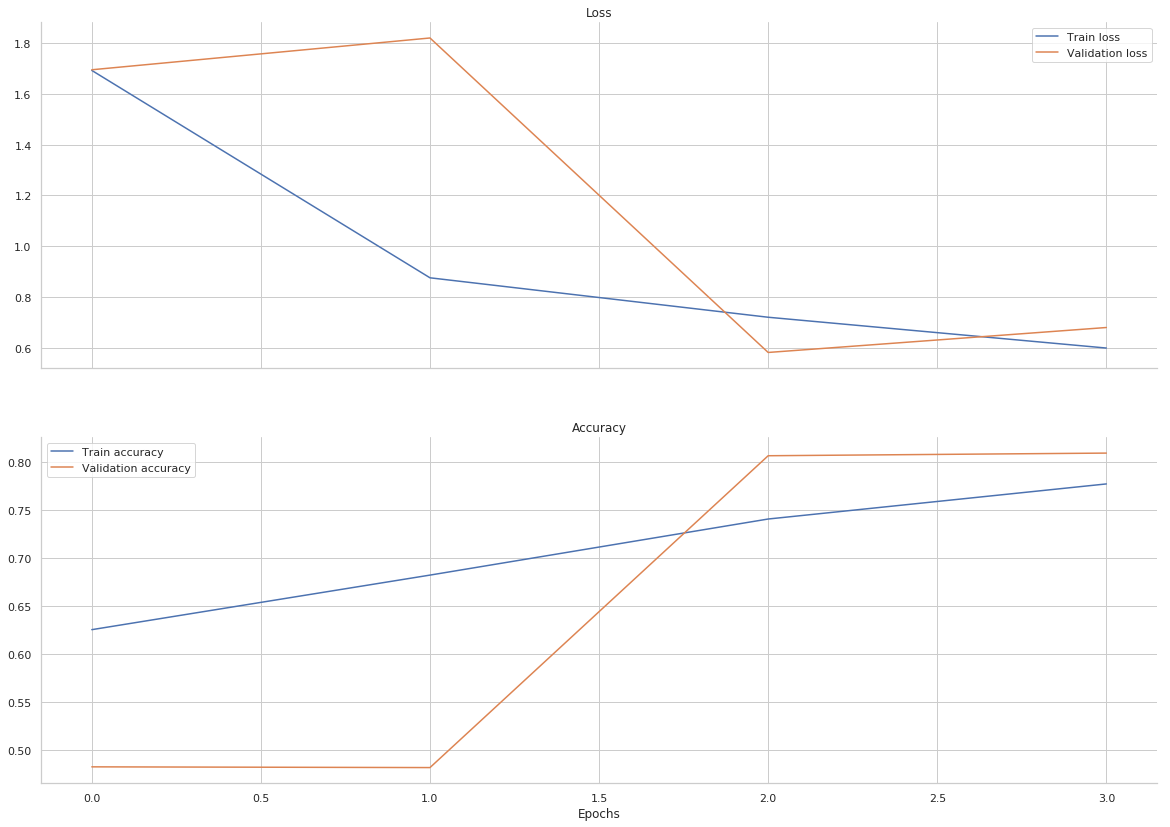

In [17]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

## Confusion Matrix

In [18]:
# # Create empty arays to keep the predictions and labels
# lastFullTrainPred = np.empty((0, N_CLASSES))
# lastFullTrainLabels = np.empty((0, N_CLASSES))
# lastFullValPred = np.empty((0, N_CLASSES))
# lastFullValLabels = np.empty((0, N_CLASSES))

# # Add train predictions and labels
# for i in range(STEP_SIZE_TRAIN+1):
#     im, lbl = next(train_generator)
#     scores = model.predict(im, batch_size=train_generator.batch_size)
#     lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
#     lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# # Add validation predictions and labels
# for i in range(STEP_SIZE_VALID+1):
#     im, lbl = next(valid_generator)
#     scores = model.predict(im, batch_size=valid_generator.batch_size)
#     lastFullValPred = np.append(lastFullValPred, scores, axis=0)
#     lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
# lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
# lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
# complete_labels = [np.argmax(label) for label in lastFullComLabels]

# train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
# train_labels = [np.argmax(label) for label in lastFullTrainLabels]
# validation_preds = [np.argmax(pred) for pred in lastFullValPred]
# validation_labels = [np.argmax(label) for label in lastFullValLabels]




from tqdm import tqdm  # Import tqdm for progress tracking

# Create empty arrays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels with a progress bar
for i in tqdm(range(STEP_SIZE_TRAIN + 1), desc="Processing training predictions"):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels with a progress bar
for i in tqdm(range(STEP_SIZE_VALID + 1), desc="Processing validation predictions"):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

# Combine predictions and labels from train and validation
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))

# Convert labels and predictions to class indices
complete_labels = [np.argmax(label) for label in lastFullComLabels]
train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]


Processing validation predictions: 100%|██████████| 92/92 [01:21<00:00,  1.02it/s]


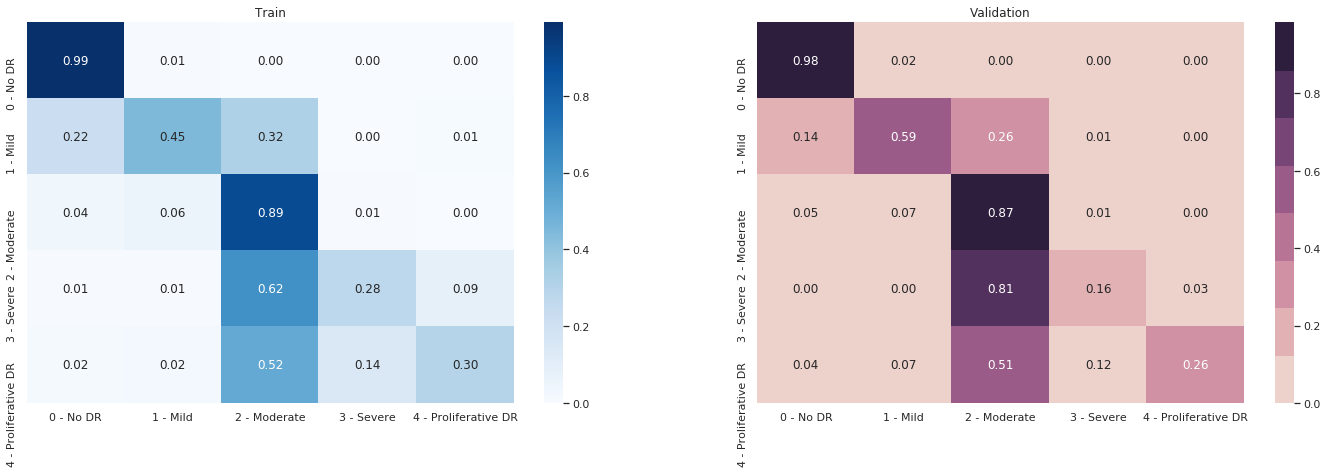

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

## Quadratic Weighted Kappa

In [19]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.868
Validation Cohen Kappa score: 0.835
Complete set Cohen Kappa score: 0.861


# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models): 
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

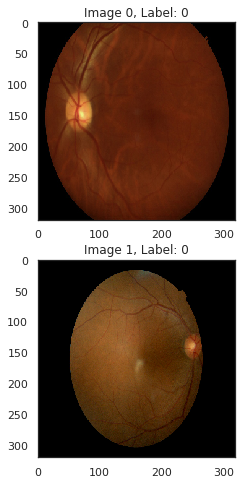

In [21]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

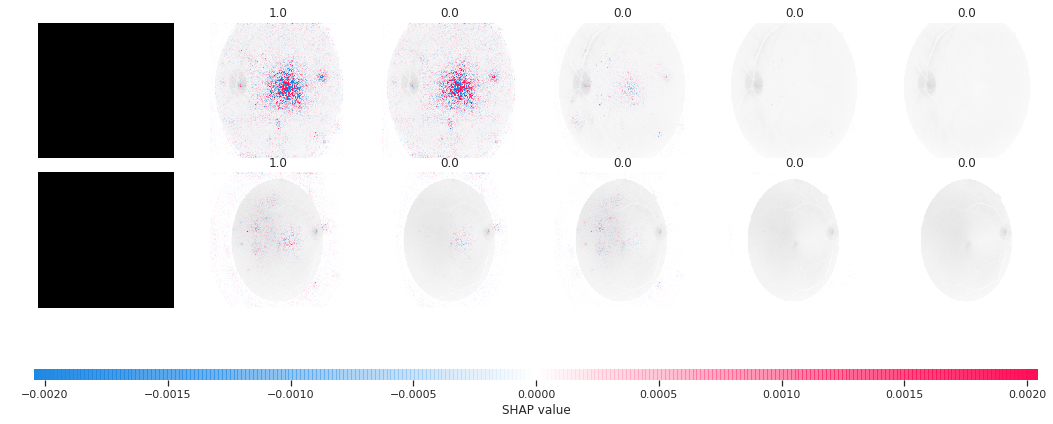

In [22]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

- The plot above explains five outputs (our five levels of diabetic retinopathy 0-5) for three different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left (they are black because most of the pixels are greater than 0), and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset, here I'm using 10 images) and the current model output. 
- Note that for the images that the label is "1.0" (the correct one), we a greater pink area.
- Labels that have as much pink area as the correct one are labels that our model probably doesn't have a high confidence prediction.

## Let's try on a few more images

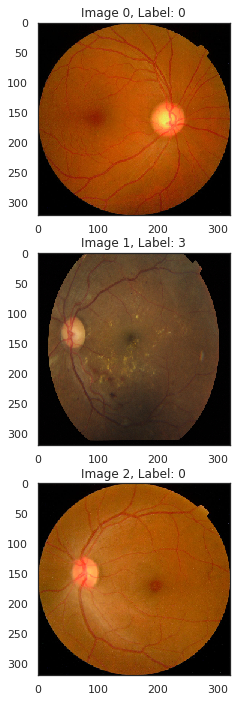

In [23]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[12, 12])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

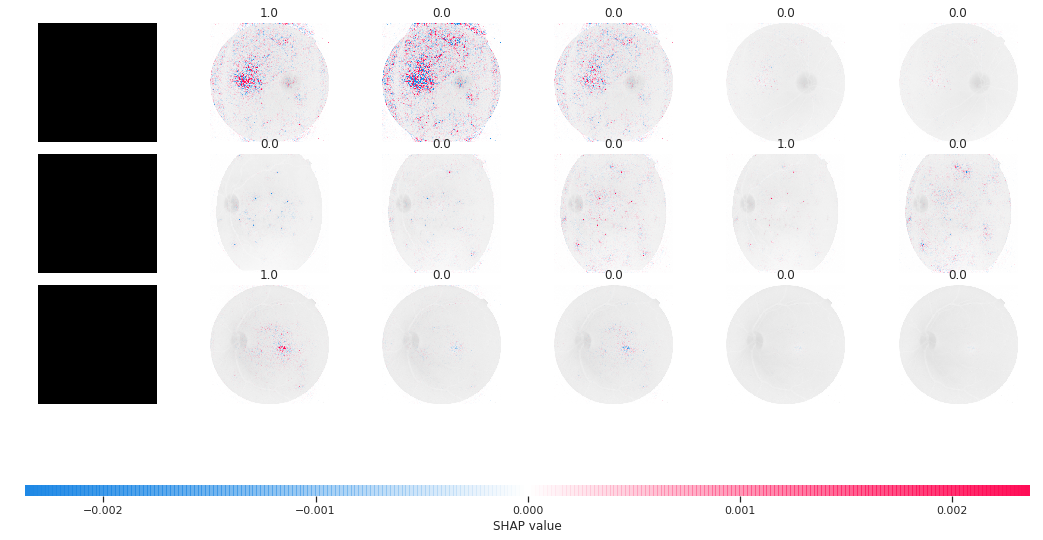

In [24]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

## Apply model to test set and output predictions

In [27]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

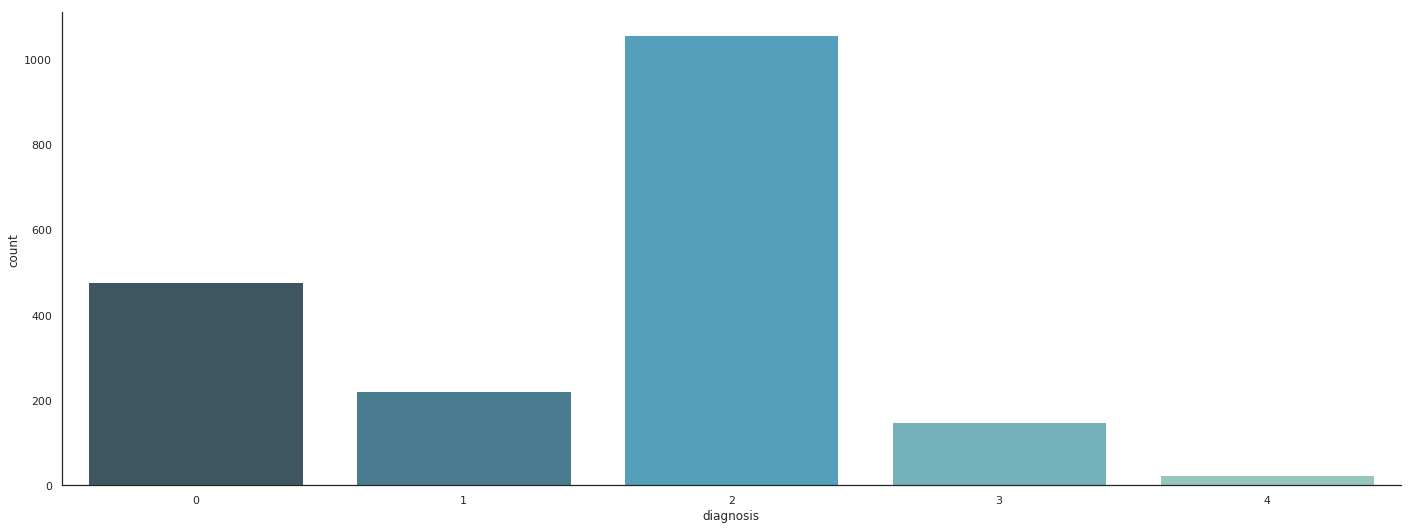

In [28]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [29]:
results.to_csv('submission.csv', index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


In [30]:
import ipywidgets as widgets
print(widgets.__version__)


7.4.2


In [31]:
print(widgets.__version__)

7.4.2


Creating Background Dataset: 100%|██████████| 10/10 [00:09<00:00,  1.03image/s]


Computing SHAP values...
Model Prediction: Moderate NPDR (Class 2) with confidence 0.35


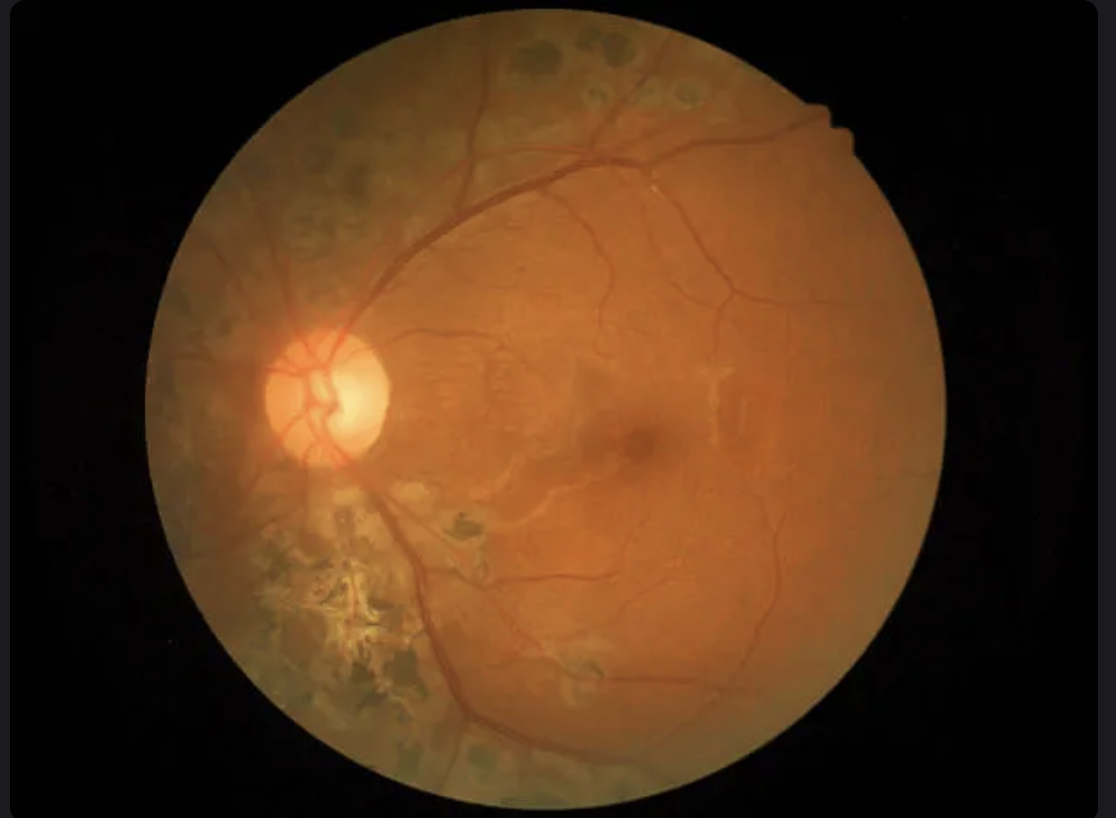

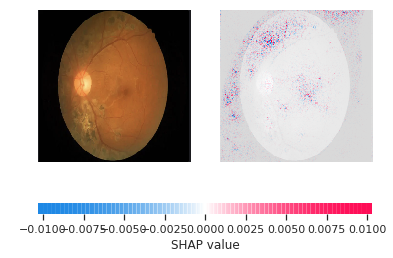


SHAP Explanation:
- Red areas indicate regions that pushed the prediction towards the displayed class (e.g., signs of DR).
- Blue areas indicate regions that pushed the prediction away from the class.
- In this example, features such as microaneurysms or hemorrhages may be highlighted if present.


In [32]:
import shap
from PIL import Image
import numpy as np
from IPython.display import display
from tqdm import tqdm  # Import tqdm for progress bar

# ------------------------------
# 1. Choose and preprocess a sample test image
# ------------------------------
# Path to a sample test image (adjust if needed)
sample_image_path = "/kaggle/input/diebetic-retina-image/Screenshot 2025-02-27 at 8.04.11PM.png"

# Load the image and convert to RGB
sample_image = Image.open(sample_image_path).convert("RGB")

# Resize to match model input size (same as used in training)
sample_image_resized = sample_image.resize((HEIGHT, WIDTH))

# Convert to array, scale pixels, and add batch dimension
sample_image_array = np.array(sample_image_resized) / 255.0
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # shape: (1, HEIGHT, WIDTH, 3)

# ------------------------------
# 2. Create a background dataset for SHAP using training images
# ------------------------------
# Reset the train_generator if needed
train_generator.reset()
background_images = []

# Use 10 images as the background sample (adjust if desired)
for _ in tqdm(range(10), desc="Creating Background Dataset", unit="image"):
    batch_im, _ = next(train_generator)
    background_images.append(batch_im[0])

background = np.array(background_images)  # shape: (10, HEIGHT, WIDTH, 3)

# ------------------------------
# 3. Compute SHAP values using DeepExplainer
# ------------------------------
print("Computing SHAP values...")
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sample_image_array)

# ------------------------------
# 4. Visualize SHAP explanations and print prediction details
# ------------------------------
# Predict the class for the sample image
preds = model.predict(sample_image_array)
predicted_class = np.argmax(preds, axis=1)[0]
confidence = float(np.max(preds))
class_names = ["No DR", "Mild NPDR", "Moderate NPDR", "Severe NPDR", "Proliferative DR"]

print(f"Model Prediction: {class_names[predicted_class]} (Class {predicted_class}) with confidence {confidence:.2f}")
display(sample_image)

# For multi-class models, shap_values is a list. We focus on the predicted class.
if isinstance(shap_values, list):
    shap.image_plot(shap_values[predicted_class], sample_image_array)
else:
    shap.image_plot(shap_values, sample_image_array)

print("\nSHAP Explanation:")
print("- Red areas indicate regions that pushed the prediction towards the displayed class (e.g., signs of DR).")
print("- Blue areas indicate regions that pushed the prediction away from the class.")
print("- In this example, features such as microaneurysms or hemorrhages may be highlighted if present.")


Creating Background Dataset: 100%|██████████| 10/10 [00:09<00:00,  1.20image/s]


Computing SHAP values...
Model Prediction: No DR (Class 0) with confidence 1.00


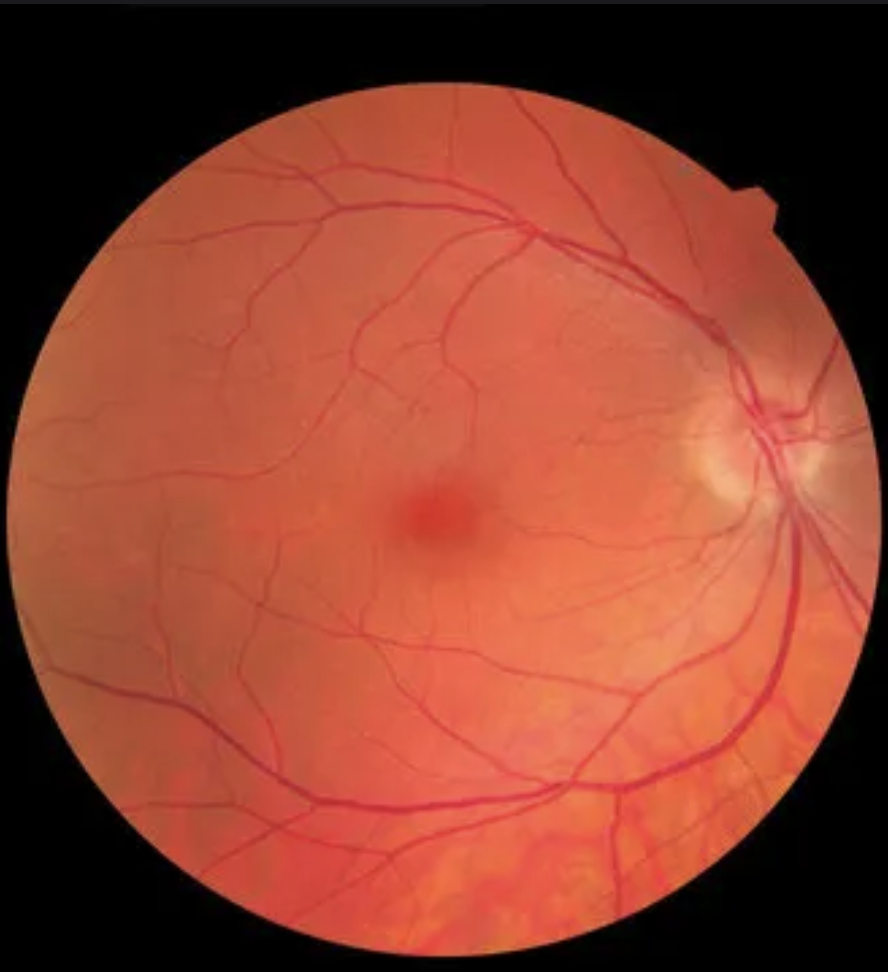

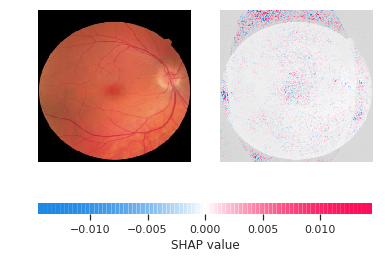


SHAP Explanation:
- Red areas indicate regions that pushed the prediction towards the displayed class (e.g., signs of DR).
- Blue areas indicate regions that pushed the prediction away from the class.
- In this example, features such as microaneurysms or hemorrhages may be highlighted if present.


In [33]:
#For healthy retina one

import shap
from PIL import Image
import numpy as np
from IPython.display import display
from tqdm import tqdm  # Import tqdm for progress bar

# ------------------------------
# 1. Choose and preprocess a sample test image
# ------------------------------
# Path to a sample test image (adjust if needed)
sample_image_path = "/kaggle/input/healthy-retina-image-from-google/Screenshot 2025-02-27 at 8.07.16PM.png"

# Load the image and convert to RGB
sample_image = Image.open(sample_image_path).convert("RGB")

# Resize to match model input size (same as used in training)
sample_image_resized = sample_image.resize((HEIGHT, WIDTH))

# Convert to array, scale pixels, and add batch dimension
sample_image_array = np.array(sample_image_resized) / 255.0
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # shape: (1, HEIGHT, WIDTH, 3)

# ------------------------------
# 2. Create a background dataset for SHAP using training images
# ------------------------------
# Reset the train_generator if needed
train_generator.reset()
background_images = []

# Use 10 images as the background sample (adjust if desired)
for _ in tqdm(range(10), desc="Creating Background Dataset", unit="image"):
    batch_im, _ = next(train_generator)
    background_images.append(batch_im[0])

background = np.array(background_images)  # shape: (10, HEIGHT, WIDTH, 3)

# ------------------------------
# 3. Compute SHAP values using DeepExplainer
# ------------------------------
print("Computing SHAP values...")
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sample_image_array)

# ------------------------------
# 4. Visualize SHAP explanations and print prediction details
# ------------------------------
# Predict the class for the sample image
preds = model.predict(sample_image_array)
predicted_class = np.argmax(preds, axis=1)[0]
confidence = float(np.max(preds))
class_names = ["No DR", "Mild NPDR", "Moderate NPDR", "Severe NPDR", "Proliferative DR"]

print(f"Model Prediction: {class_names[predicted_class]} (Class {predicted_class}) with confidence {confidence:.2f}")
display(sample_image)

# For multi-class models, shap_values is a list. We focus on the predicted class.
if isinstance(shap_values, list):
    shap.image_plot(shap_values[predicted_class], sample_image_array)
else:
    shap.image_plot(shap_values, sample_image_array)

print("\nSHAP Explanation:")
print("- Red areas indicate regions that pushed the prediction towards the displayed class (e.g., signs of DR).")
print("- Blue areas indicate regions that pushed the prediction away from the class.")
print("- In this example, features such as microaneurysms or hemorrhages may be highlighted if present.")


Creating Background Dataset: 100%|██████████| 10/10 [00:10<00:00,  1.03s/image]


Computing SHAP values...
Model Prediction: Moderate NPDR (Class 2) with confidence 0.80


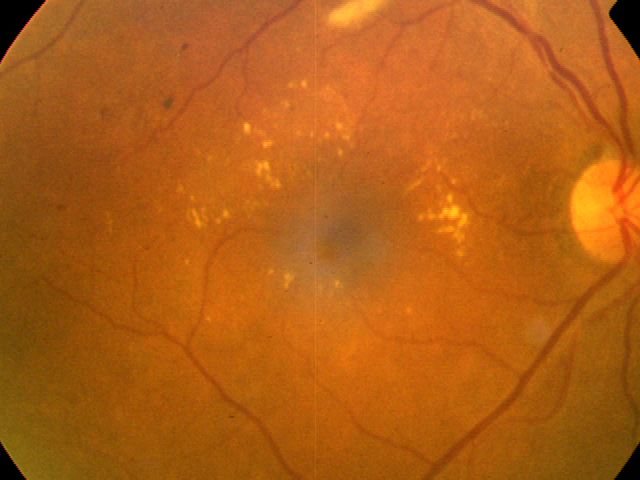

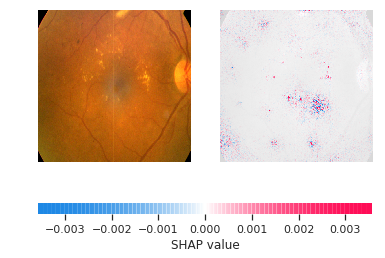


Dynamic SHAP Explanation:
In this image, approximately 51.2% of the pixels contribute positively (red) towards the prediction, indicating regions that push the model toward Moderate NPDR.
Conversely, about 48.8% of the pixels contribute negatively (blue), counteracting that prediction.
There is a moderate level of positive contributions, suggesting that localized regions of the retina exhibit features consistent with diabetic retinopathy.

Note: These explanations are generated by the SHAP model and should be interpreted as part of a decision-support system rather than a definitive diagnosis.


In [34]:
import shap
from PIL import Image
import numpy as np
from IPython.display import display
from tqdm import tqdm  # for the progress bar

# ------------------------------
# 1. Choose and preprocess a sample test image
# ------------------------------
sample_image_path = "/kaggle/input/aptos2019-blindness-detection/test_images/00836aaacf06.png"

# Load the image and convert to RGB
sample_image = Image.open(sample_image_path).convert("RGB")
# Resize to match model input size (same as used in training)
sample_image_resized = sample_image.resize((HEIGHT, WIDTH))
# Convert to array, scale pixels, and add batch dimension
sample_image_array = np.array(sample_image_resized) / 255.0
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # shape: (1, HEIGHT, WIDTH, 3)

# ------------------------------
# 2. Create a background dataset for SHAP using training images
# ------------------------------
train_generator.reset()
background_images = []
# Use 10 images as the background sample (adjust if desired)
for _ in tqdm(range(10), desc="Creating Background Dataset", unit="image"):
    batch_im, _ = next(train_generator)
    background_images.append(batch_im[0])
background = np.array(background_images)  # shape: (10, HEIGHT, WIDTH, 3)

# ------------------------------
# 3. Compute SHAP values using DeepExplainer
# ------------------------------
print("Computing SHAP values...")
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sample_image_array)

# ------------------------------
# 4. Visualize SHAP explanations and print prediction details
# ------------------------------
# Predict the class for the sample image
preds = model.predict(sample_image_array)
predicted_class = np.argmax(preds, axis=1)[0]
confidence = float(np.max(preds))
class_names = ["No DR", "Mild NPDR", "Moderate NPDR", "Severe NPDR", "Proliferative DR"]

print(f"Model Prediction: {class_names[predicted_class]} (Class {predicted_class}) with confidence {confidence:.2f}")
display(sample_image)

# For multi-class models, shap_values is a list. We focus on the predicted class.
if isinstance(shap_values, list):
    shap_val = shap_values[predicted_class]
    shap.image_plot(shap_val, sample_image_array)
    # Extract the explanation for our single image (remove batch dimension)
    shap_val_img = shap_val[0]
else:
    shap.image_plot(shap_values, sample_image_array)
    shap_val_img = shap_values[0]

# ------------------------------
# 5. Dynamic SHAP Explanation (Realtime)
# ------------------------------
# Average over channels so we get one contribution value per pixel.
pixel_contributions = np.mean(shap_val_img, axis=-1)  # shape: (HEIGHT, WIDTH)

# Count the positive (red) and negative (blue) contributions
positive_pixels = np.sum(pixel_contributions > 0)
negative_pixels = np.sum(pixel_contributions < 0)
total_pixels = pixel_contributions.size

pos_percent = (positive_pixels / total_pixels) * 100
neg_percent = (negative_pixels / total_pixels) * 100

print("\nDynamic SHAP Explanation:")
print(f"In this image, approximately {pos_percent:.1f}% of the pixels contribute positively (red) towards the prediction, indicating regions that push the model toward {class_names[predicted_class]}.")
print(f"Conversely, about {neg_percent:.1f}% of the pixels contribute negatively (blue), counteracting that prediction.")

# Provide an interpretation based on the positive contribution percentage
if pos_percent > 60:
    print("The high proportion of positive contributions suggests that widespread retinal features indicative of diabetic retinopathy are present.")
elif pos_percent > 40:
    print("There is a moderate level of positive contributions, suggesting that localized regions of the retina exhibit features consistent with diabetic retinopathy.")
else:
    print("The majority of the image contributes negatively, indicating minimal evidence of diabetic retinopathy features in this sample.")

print("\nNote: These explanations are generated by the SHAP model and should be interpreted as part of a decision-support system rather than a definitive diagnosis.")


In [ ]:
import shap
from PIL import Image
import numpy as np
from IPython.display import display
from tqdm import tqdm  # for the progress bar

# ------------------------------
# 1. Choose and preprocess a sample test image
# ------------------------------
sample_image_path = "/kaggle/input/aptos2019-blindness-detection/test_images/00836aaacf06.png"

# Load the image and convert to RGB
sample_image = Image.open(sample_image_path).convert("RGB")
# Resize to match model input size (same as used in training)
sample_image_resized = sample_image.resize((HEIGHT, WIDTH))
# Convert to array, scale pixels, and add batch dimension
sample_image_array = np.array(sample_image_resized) / 255.0
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # shape: (1, HEIGHT, WIDTH, 3)

# ------------------------------
# 2. Create a background dataset for SHAP using training images
# ------------------------------
train_generator.reset()
background_images = []
# Use 10 images as the background sample (adjust if desired)
for _ in tqdm(range(10), desc="Creating Background Dataset", unit="image"):
    batch_im, _ = next(train_generator)
    background_images.append(batch_im[0])
background = np.array(background_images)  # shape: (10, HEIGHT, WIDTH, 3)

# ------------------------------
# 3. Compute SHAP values using DeepExplainer
# ------------------------------
print("Computing SHAP values...")
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sample_image_array)

# ------------------------------
# 4. Visualize SHAP explanations and print prediction details
# ------------------------------
# Predict the class for the sample image
preds = model.predict(sample_image_array)
predicted_class = np.argmax(preds, axis=1)[0]
confidence = float(np.max(preds))
class_names = ["No DR", "Mild NPDR", "Moderate NPDR", "Severe NPDR", "Proliferative DR"]

print(f"Model Prediction: {class_names[predicted_class]} (Class {predicted_class}) with confidence {confidence:.2f}")
display(sample_image)

# For multi-class models, shap_values is a list. We focus on the predicted class.
if isinstance(shap_values, list):
    shap_val = shap_values[predicted_class]
    shap.image_plot(shap_val, sample_image_array)
    # Extract the explanation for our single image (remove batch dimension)
    shap_val_img = shap_val[0]
else:
    shap.image_plot(shap_values, sample_image_array)
    shap_val_img = shap_values[0]

# ------------------------------
# 5. Dynamic SHAP Explanation (Realtime)
# ------------------------------
# Average over channels so we get one contribution value per pixel.
pixel_contributions = np.mean(shap_val_img, axis=-1)  # shape: (HEIGHT, WIDTH)

# Count the positive (red) and negative (blue) contributions
positive_pixels = np.sum(pixel_contributions > 0)
negative_pixels = np.sum(pixel_contributions < 0)
total_pixels = pixel_contributions.size

pos_percent = (positive_pixels / total_pixels) * 100
neg_percent = (negative_pixels / total_pixels) * 100

print("\nDynamic SHAP Explanation:")
print(f"In this image, approximately {pos_percent:.1f}% of the pixels contribute positively (red) towards the prediction, indicating regions that push the model toward {class_names[predicted_class]}.")
print(f"Conversely, about {neg_percent:.1f}% of the pixels contribute negatively (blue), counteracting that prediction.")

# Provide an interpretation based on the positive contribution percentage
if pos_percent > 60:
    print("The high proportion of positive contributions suggests that widespread retinal features indicative of diabetic retinopathy are present.")
elif pos_percent > 40:
    print("There is a moderate level of positive contributions, suggesting that localized regions of the retina exhibit features consistent with diabetic retinopathy.")
else:
    print("The majority of the image contributes negatively, indicating minimal evidence of diabetic retinopathy features in this sample.")

print("\nNote: These explanations are generated by the SHAP model and should be interpreted as part of a decision-support system rather than a definitive diagnosis.")


In [ ]:
import shap
from PIL import Image
import numpy as np
from IPython.display import display
from tqdm import tqdm  # for the progress bar
import matplotlib.pyplot as plt

# ------------------------------
# 1. Set up dimensions based on model input shape
# ------------------------------
# If your model's input shape is defined, use it.
# model.input_shape is typically (None, height, width, channels)
input_shape = model.input_shape
if input_shape[1] is None or input_shape[2] is None:
    # Fallback default if input dimensions are not specified
    HEIGHT, WIDTH = 320, 320
else:
    HEIGHT, WIDTH = input_shape[1], input_shape[2]
print(f"Using image dimensions: {HEIGHT}x{WIDTH}")

# ------------------------------
# 2. Create a background dataset for SHAP using training images
# ------------------------------
print("Creating background dataset from training images...")
train_generator.reset()
background_images = []
# Use 10 images as the background sample (adjust if desired)
for _ in tqdm(range(10), desc="Creating Background Dataset", unit="image"):
    batch_im, _ = next(train_generator)
    # The training generator might output images at a different size.
    # Convert the first image of the batch to a PIL image, then resize it.
    pil_img = Image.fromarray((batch_im[0] * 255).astype(np.uint8))
    pil_img_resized = pil_img.resize((WIDTH, HEIGHT))
    resized_img = np.array(pil_img_resized) / 255.0
    background_images.append(resized_img)
background = np.array(background_images)  # shape: (10, HEIGHT, WIDTH, 3)

# ------------------------------
# 3. Initialize SHAP DeepExplainer with the background dataset
# ------------------------------
print("Initializing SHAP explainer...")
explainer = shap.DeepExplainer(model, background)

# Define class names corresponding to model outputs
class_names = ["No DR", "Mild NPDR", "Moderate NPDR", "Severe NPDR", "Proliferative DR"]

# ------------------------------
# 4. Interactive loop for SHAP explanations on user-provided images
# ------------------------------
while True:
    image_path = input("\nEnter retina image path (or 'q' to quit): ").strip()
    if image_path.lower() in ['q', 'quit']:
        print("Exiting interactive session.")
        break
    
    try:
        # --- Load and preprocess the test image ---
        sample_image = Image.open(image_path).convert("RGB")
        sample_image_resized = sample_image.resize((WIDTH, HEIGHT))
        sample_image_array = np.array(sample_image_resized) / 255.0
        sample_image_array = np.expand_dims(sample_image_array, axis=0)  # shape: (1, HEIGHT, WIDTH, 3)
        
        # --- Get model prediction ---
        preds = model.predict(sample_image_array)
        predicted_class = np.argmax(preds, axis=1)[0]
        confidence = float(np.max(preds))
        
        print(f"\nModel Prediction: {class_names[predicted_class]} (Class {predicted_class}) with confidence {confidence:.2f}")
        display(sample_image)
        
        # --- Compute SHAP values ---
        print("Computing SHAP values...")
        shap_values = explainer.shap_values(sample_image_array)
        
        # --- Visualize SHAP explanation ---
        if isinstance(shap_values, list):
            shap_val = shap_values[predicted_class]
            shap.image_plot(shap_val, sample_image_array)
            # Extract the explanation for our single image (remove batch dimension)
            shap_val_img = shap_val[0]
        else:
            shap.image_plot(shap_values, sample_image_array)
            shap_val_img = shap_values[0]
        
        # --- Dynamic SHAP Explanation (Realtime) ---
        # Average over channels to get one contribution value per pixel.
        pixel_contributions = np.mean(shap_val_img, axis=-1)  # shape: (HEIGHT, WIDTH)
        positive_pixels = np.sum(pixel_contributions > 0)
        negative_pixels = np.sum(pixel_contributions < 0)
        total_pixels = pixel_contributions.size
        
        pos_percent = (positive_pixels / total_pixels) * 100
        neg_percent = (negative_pixels / total_pixels) * 100
        
        print("\nDynamic SHAP Explanation:")
        print(f"In this image, approximately {pos_percent:.1f}% of the pixels contribute positively (red) towards the prediction, indicating regions that push the model toward {class_names[predicted_class]}.")
        print(f"Conversely, about {neg_percent:.1f}% of the pixels contribute negatively (blue), counteracting that prediction.")
        
        # Provide an interpretation based on the positive contribution percentage
        if pos_percent > 60:
            print("The high proportion of positive contributions suggests that widespread retinal features indicative of diabetic retinopathy are present.")
        elif pos_percent > 40:
            print("There is a moderate level of positive contributions, suggesting that localized regions of the retina exhibit features consistent with diabetic retinopathy.")
        else:
            print("The majority of the image contributes negatively, indicating minimal evidence of diabetic retinopathy features in this sample.")
        
        print("\nNote: These explanations are generated by the SHAP model and should be interpreted as part of a decision-support system rather than a definitive diagnosis.")
    
    except Exception as e:
        print(f"Error processing image: {e}")
